In [1]:
# Running PyTorch on MPS
import torch
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
from PIL import Image

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [19]:
test_dir = Path("test/")
train_dir = Path("train/")

In [20]:
train_path_list = list(train_dir.glob("*/*.png"))
test_path_list = list(test_dir.glob("*/*.png"))

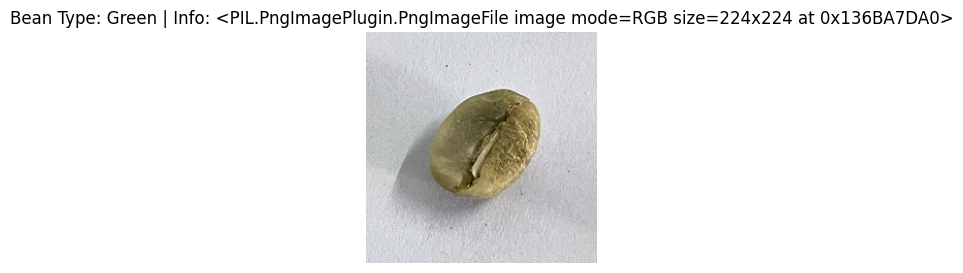

In [4]:
# Open random image to check if working

rand_img_path = random.choice(train_path_list)
img_class = rand_img_path.parent.stem
img = Image.open(rand_img_path)

# print(img, img_class)
img_as_arr = np.asarray(img)

plt.figure(figsize=(3,3))
plt.imshow(img_as_arr)
plt.title(f"Bean Type: {img_class} | Info: {img}")
plt.axis(False);

In [23]:
# PARAMETERS
effnetv2_s_weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
effnetv2_s_transforms = effnetv2_s_weights.transforms()
effnetb1_weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
effnetb1_transforms = effnetb1_weights.transforms()

BATCH_SIZE = 32
NUM_WORKERS = 0 # for mps activation
effnetv2_s_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [24]:
train_data = datasets.ImageFolder(train_dir, transform=effnetv2_s_transforms)
test_data = datasets.ImageFolder(test_dir, transform=effnetv2_s_transforms)
train_data, test_data
class_names = train_data.classes
class_names

['Dark', 'Green', 'Light', 'Medium']

In [25]:
# Import Model
from torchinfo import summary

effnetv2_s = torchvision.models.efficientnet_v2_s(weights=effnetv2_s_weights)

for params in effnetv2_s.parameters():
    params.requires_grad = False


effnetv2_s.classifier = torch.nn.Sequential(
    nn.Dropout(p=0, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(mps_device)
)

summary(effnetv2_s, 
        input_size=(1, 3, 384, 384),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 384, 384]     [1, 4]               --                   Partial
├─Sequential (features)                                      [1, 3, 384, 384]     [1, 1280, 12, 12]    --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 384, 384]     [1, 24, 192, 192]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 384, 384]     [1, 24, 192, 192]    (648)                False
│    │    └─BatchNorm2d (1)                                  [1, 24, 192, 192]    [1, 24, 192, 192]    (48)                 False
│    │    └─SiLU (2)                                         [1, 24, 192, 192]    [1, 24, 192, 192]    --                   --
│    └─Sequential (1)                                        [1, 24, 192, 192]    [1, 2

In [8]:
# Dataloaders 
train_dataloader = DataLoader(train_data, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True,
                               num_workers=NUM_WORKERS,
                               pin_memory=True)

test_dataloader = DataLoader(test_data, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False,
                               num_workers=NUM_WORKERS,
                               pin_memory=True)

In [3]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X).to(device)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [4]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os

def model_writer(model: str,
                 add: str=None) -> torch.utils.tensorboard.SummaryWriter:

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if add:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, model, add)
    else:
        log_dir = os.path.join("runs", timestamp, model)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [5]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          writer: torch.utils.tensorboard.SummaryWriter,
          device: torch.device) -> Dict[str, List]: # {name of metric, list of scalar data for epoch}

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        ### New: Experiment tracking ###
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetv2_s.parameters(), lr=0.001)

results = train(model=effnetv2_s.to(mps_device),
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                writer=effnetv2_s_writer,
                device=mps_device)

NameError: name 'effnetv2_s' is not defined

In [9]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                          exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
               f=model_save_path)


In [12]:
from model_builder import build_effnet_v2_s, build_effnetb1
from data_setup import create_dataloaders
from utils import save_model

experiment_number = 0

models = ["effnet_v2_s", "effnetb1"]
num_epochs = [5, 10]

for epochs in num_epochs:
    for model_name in models:
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # Select the model
            if model_name == "effnet_v2_s":
                model, weights = build_effnet_v2_s(mps_device)
            else:
                model, weights = build_effnetb1(mps_device)
                
            # Get DataLoaders
            train_dataloader, test_dataloader = create_dataloaders(train_dir,
                                                       test_dir,
                                                       transform=weights.transforms(),
                                                       batch_size=32,
                                                       num_workers=0)
            
            # Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # Train target model with target dataloaders and track experiments
            train(model=model.to(mps_device) ,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=mps_device,
                  writer=model_writer(model_name,
                                       add=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnet_v2_s
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2024-07-13/effnet_v2_s/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8720 | train_acc: 0.7730 | test_loss: 0.4856 | test_acc: 0.9447
Epoch: 2 | train_loss: 0.4146 | train_acc: 0.9424 | test_loss: 0.2957 | test_acc: 0.9423
Epoch: 3 | train_loss: 0.2897 | train_acc: 0.9539 | test_loss: 0.1948 | test_acc: 0.9784
Epoch: 4 | train_loss: 0.2271 | train_acc: 0.9638 | test_loss: 0.1599 | test_acc: 0.9832
Epoch: 5 | train_loss: 0.1972 | train_acc: 0.9581 | test_loss: 0.1356 | test_acc: 0.9832
[INFO] Saving model to: models/07_effnet_v2_s_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb1
[INFO] Number of epochs: 5


Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /Users/seunghyunlee/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|███████████████████████████████████████████████████| 30.1M/30.1M [00:00<00:00, 36.6MB/s]


[INFO] Created SummaryWriter, saving to: runs/2024-07-13/effnetb1/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9412 | train_acc: 0.8470 | test_loss: 0.5830 | test_acc: 0.9832
Epoch: 2 | train_loss: 0.4583 | train_acc: 0.9646 | test_loss: 0.3088 | test_acc: 0.9952
Epoch: 3 | train_loss: 0.2889 | train_acc: 0.9737 | test_loss: 0.2022 | test_acc: 0.9976
Epoch: 4 | train_loss: 0.2283 | train_acc: 0.9737 | test_loss: 0.1623 | test_acc: 0.9976
Epoch: 5 | train_loss: 0.1743 | train_acc: 0.9860 | test_loss: 0.1202 | test_acc: 0.9976
[INFO] Saving model to: models/07_effnetb1_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnet_v2_s
[INFO] Number of epochs: 10
[INFO] Created SummaryWriter, saving to: runs/2024-07-13/effnet_v2_s/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9002 | train_acc: 0.7673 | test_loss: 0.4969 | test_acc: 0.9327
Epoch: 2 | train_loss: 0.4267 | train_acc: 0.9408 | test_loss: 0.2881 | test_acc: 0.9712
Epoch: 3 | train_loss: 0.3005 | train_acc: 0.9408 | test_loss: 0.2080 | test_acc: 0.9760
Epoch: 4 | train_loss: 0.2500 | train_acc: 0.9490 | test_loss: 0.1640 | test_acc: 0.9832
Epoch: 5 | train_loss: 0.2125 | train_acc: 0.9581 | test_loss: 0.1373 | test_acc: 0.9808
Epoch: 6 | train_loss: 0.1818 | train_acc: 0.9704 | test_loss: 0.1220 | test_acc: 0.9856
Epoch: 7 | train_loss: 0.1653 | train_acc: 0.9704 | test_loss: 0.0996 | test_acc: 0.9856
Epoch: 8 | train_loss: 0.1545 | train_acc: 0.9630 | test_loss: 0.0910 | test_acc: 0.9880
Epoch: 9 | train_loss: 0.1303 | train_acc: 0.9745 | test_loss: 0.1954 | test_acc: 0.9904
Epoch: 10 | train_loss: 0.1134 | train_acc: 0.9786 | test_loss: 0.0759 | test_acc: 0.9832
[INFO] Saving model to: models/07_effnet_v2_s_10_epochs.pth
-------------------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9094 | train_acc: 0.9021 | test_loss: 0.5563 | test_acc: 0.9808
Epoch: 2 | train_loss: 0.4350 | train_acc: 0.9597 | test_loss: 0.2925 | test_acc: 0.9928
Epoch: 3 | train_loss: 0.2907 | train_acc: 0.9786 | test_loss: 0.1978 | test_acc: 0.9952
Epoch: 4 | train_loss: 0.2072 | train_acc: 0.9836 | test_loss: 0.1510 | test_acc: 0.9976
Epoch: 5 | train_loss: 0.1755 | train_acc: 0.9811 | test_loss: 0.1200 | test_acc: 0.9928
Epoch: 6 | train_loss: 0.1495 | train_acc: 0.9803 | test_loss: 0.1022 | test_acc: 0.9976
Epoch: 7 | train_loss: 0.1286 | train_acc: 0.9811 | test_loss: 0.0837 | test_acc: 0.9976
Epoch: 8 | train_loss: 0.1150 | train_acc: 0.9860 | test_loss: 0.0710 | test_acc: 0.9976
Epoch: 9 | train_loss: 0.1019 | train_acc: 0.9844 | test_loss: 0.0650 | test_acc: 0.9976
Epoch: 10 | train_loss: 0.0864 | train_acc: 0.9910 | test_loss: 0.0573 | test_acc: 0.9976
[INFO] Saving model to: models/07_effnetb1_10_epochs.pth
--------------------------------------------------



In [13]:
%load_ext tensorboard
%tensorboard --logdir runs

In [34]:
"""
Utility functions to make predictions.

Main reference for code creation: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set 
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (255, 255),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure(figsize=(5,6))
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)



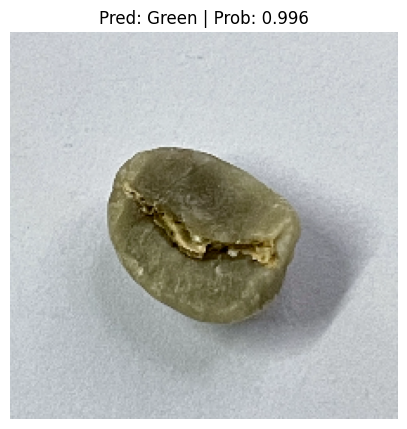

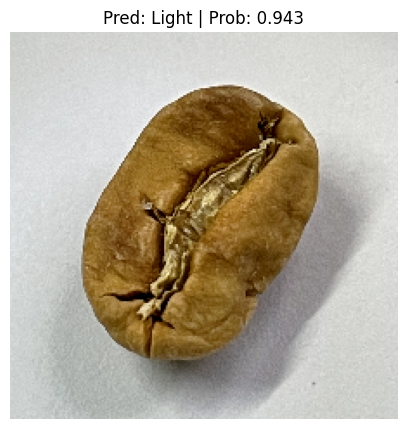

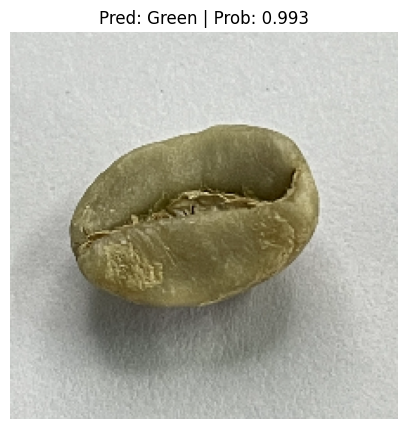

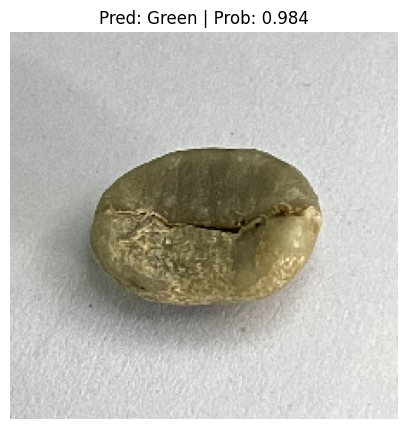

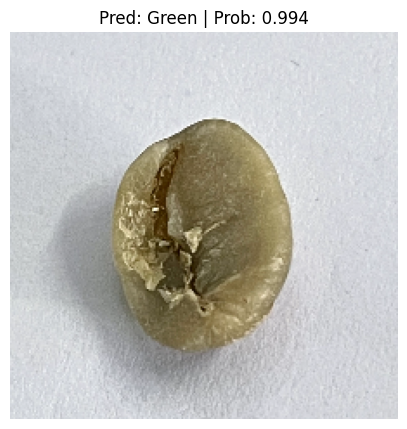

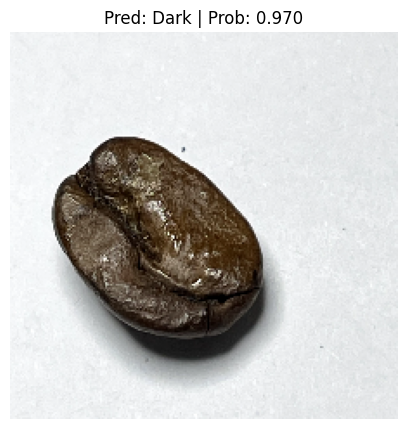

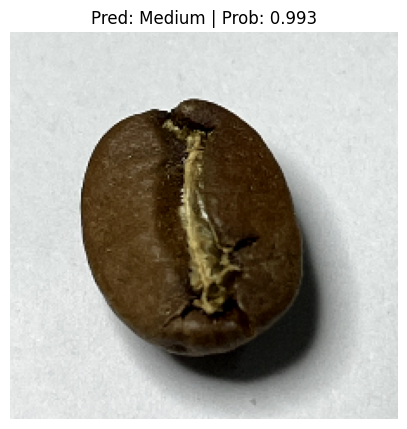

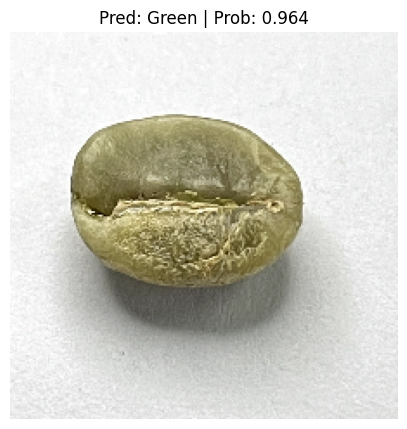

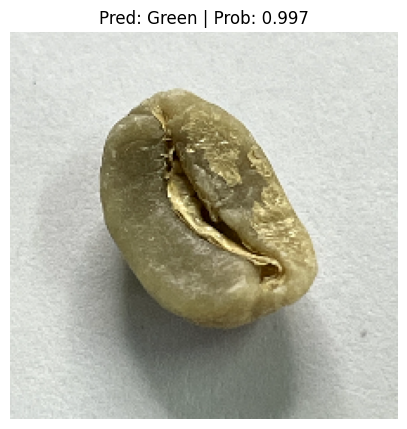

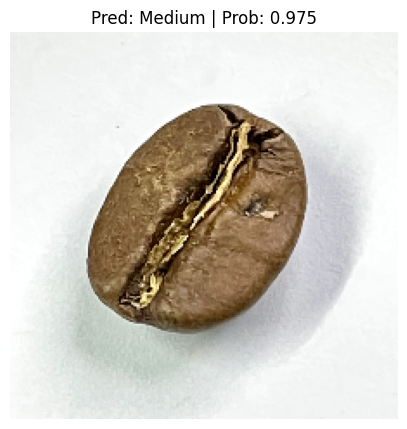

In [46]:
best_model_path = "models/effnetb1_10_epochs.pth"
best_model, weights = build_effnetb1(mps_device)
best_model.load_state_dict(torch.load(best_model_path))


import random
num_images_to_plot = 10
test_image_path_sample = random.sample(population=test_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# test_image_path_sample = [Path("internet.png"), Path("greeny.png"), Path("green2.jpg"), Path("dark.jpg")]

# # Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(255, 255))